In [1]:
from matplotlib import pyplot as plt
from nettack import utils
from nettack.utils import accuracy
import numpy as np
import scipy.sparse as sp
from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.module import Module
from torch.nn.parameter import Parameter
import torch
import math
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:2')
_A_obs, _X_obs, _z_obs= utils.load_npz('data/cora.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1

_X_obs = utils.preprocess_feats(_X_obs.astype('float32'))

edge_index = []
edge_index.append(_A_obs.tocoo().row.tolist())
edge_index.append(_A_obs.tocoo().col.tolist())

idx = np.arange(len(edge_index[0]))
seed = 15
np.random.seed(seed)
np.random.shuffle(idx)

idx_train = idx[:int(len(edge_index[0])*0.7)]
idx_test = idx[int(len(edge_index[0])*0.7):]


feats = torch.FloatTensor(_X_obs.toarray()).to(device)



edge_index = np.array(edge_index).T
edge_train = torch.LongTensor(edge_index[idx_train]).to(device)
edge_test  = torch.LongTensor(edge_index[idx_test]).to(device)

train_edge_dict = defaultdict(lambda: defaultdict(lambda: False))
for e in edge_index[idx_train]:
    train_edge_dict[e[0]][e[1]] = True
    train_edge_dict[e[1]][e[0]] = True
    
test_edge_dict  = defaultdict(lambda: defaultdict(lambda: False))
for e in edge_index:
    test_edge_dict[e[0]][e[1]] = True
    test_edge_dict[e[1]][e[0]] = True
    
train_edge_ori_dict = {}
for t in train_edge_dict:
    train_edge_ori_dict[t] = []
    for s in train_edge_dict[t]:
        if train_edge_dict[t][s] == True:
            train_edge_ori_dict[t] += [s]

In [3]:
class SGC(nn.Module):
    def __init__(self, n_input, n_output):
        super(SGC, self).__init__()
        self.conv1 = GCNConv(n_input, 128,  cached=False)
        self.conv2 = GCNConv(128, n_output, cached=False)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x
class LinkPredictor(nn.Module):
    def __init__(self, n_hid):
        super(LinkPredictor, self).__init__()
        self.linear = nn.Linear(n_hid, n_hid)
        self.adjust = nn.Linear(n_hid, 1)
    def forward(self, xi, xj):
        return self.adjust(self.linear(xi) * xj)

In [4]:
model = SGC(_X_obs.shape[1], 32).to(device)
linkpredictor = LinkPredictor(32).to(device)
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), weight_decay = 5e-5),
    dict(params=linkpredictor.parameters(), weight_decay = 1e-4)
])

In [5]:
def negative_sample(s, d, samp_num, size):
    neg_list = {}
    while len(neg_list) < samp_num:
        t = np.random.randint(size)
        if d[s][t] or t in neg_list:
            continue
        neg_list[t] = True
    return list(neg_list.keys())

In [6]:
bsz = 128
samp_n = 7
epoch_n = 100
node_size = _A_obs.shape[0]
for epoch in range(epoch_n):
    for i in range(len(edge_train) // bsz):
        optimizer.zero_grad()
        model.train()
        rm_e = edge_train[i * bsz: (i+1) * bsz]
        lf_e = torch.cat((edge_train[: i * bsz], edge_train[(i+1) * bsz: ]))
        
        rep  = model.forward(feats, lf_e.t())
        pos_e = rm_e
        neg_e = []
        for s in rm_e[:, 0].cpu().tolist():
            neg_t = negative_sample(s, train_edge_dict, samp_n, node_size)
            for t in neg_t:
                neg_e += [[s, t]]
        neg_e = np.array(neg_e)
        
        
        pos_res = linkpredictor(rep[pos_e[:,0]], rep[pos_e[:,1]])
        neg_res = linkpredictor(rep[neg_e[:,0]], rep[neg_e[:,1]])
        
        res = torch.cat((pos_res, neg_res.reshape(-1, samp_n)), dim=-1)
        res = torch.log_softmax(res, dim=-1)
        
        loss = -res[:,0].mean()
        loss.backward()
        
        optimizer.step()
    model.eval()
    rep  = model.forward(feats, edge_train.t())
    rm_e = edge_test
    pos_e = rm_e
    neg_e = []
    for s in rm_e[:,0].cpu().tolist():
        neg_t = negative_sample(s, test_edge_dict, samp_n, node_size)
        for t in neg_t:
            neg_e += [[s, t]]
    neg_e = np.array(neg_e)
        
    pos_res = linkpredictor(rep[pos_e[:,0]], rep[pos_e[:,1]])
    neg_res = linkpredictor(rep[neg_e[:,0]], rep[neg_e[:,1]])
        
    res = torch.cat((pos_res, neg_res.reshape(-1, samp_n)), dim=-1)
    res = torch.softmax(res, dim=-1)
    print("Epoch: %d / %d, Probability: %.2f" % (epoch, epoch_n, res[:,0].mean().detach().tolist()))

Epoch: 0 / 100, Probability: 0.14
Epoch: 1 / 100, Probability: 0.19
Epoch: 2 / 100, Probability: 0.20
Epoch: 3 / 100, Probability: 0.21
Epoch: 4 / 100, Probability: 0.23
Epoch: 5 / 100, Probability: 0.24
Epoch: 6 / 100, Probability: 0.27
Epoch: 7 / 100, Probability: 0.29
Epoch: 8 / 100, Probability: 0.29
Epoch: 9 / 100, Probability: 0.31
Epoch: 10 / 100, Probability: 0.31
Epoch: 11 / 100, Probability: 0.31
Epoch: 12 / 100, Probability: 0.32
Epoch: 13 / 100, Probability: 0.32
Epoch: 14 / 100, Probability: 0.32
Epoch: 15 / 100, Probability: 0.33
Epoch: 16 / 100, Probability: 0.33
Epoch: 17 / 100, Probability: 0.34
Epoch: 18 / 100, Probability: 0.34
Epoch: 19 / 100, Probability: 0.35
Epoch: 20 / 100, Probability: 0.35
Epoch: 21 / 100, Probability: 0.35
Epoch: 22 / 100, Probability: 0.36
Epoch: 23 / 100, Probability: 0.37
Epoch: 24 / 100, Probability: 0.37
Epoch: 25 / 100, Probability: 0.38
Epoch: 26 / 100, Probability: 0.39
Epoch: 27 / 100, Probability: 0.40
Epoch: 28 / 100, Probability: 

In [7]:
def MRR(target,feats, edge_train):
    rep = model.forward(feats, edge_train.t())
    size = len(feats)
    sources = rep.repeat(size, 1).view(size, size, -1).transpose(0, 1).reshape(size * size, -1)
    targets = rep.repeat(size, 1)
    results = linkpredictor(sources, targets).view(size, size)

    ranks   = results.argsort(dim=-1, descending = True)
    rranks  = (ranks == target).argmax(dim=-1) + 1
    
    softmaxs = torch.softmax(results, dim=-1)[:, target]
    res = (1.0 / rranks.float()).mean().detach().cpu().tolist(), softmaxs.mean().detach().cpu().tolist()
    del rep, sources, targets, results, ranks, rranks, softmaxs
    torch.cuda.empty_cache()
    return res
    
#     for source in range(feats.shape[0]):
#         score = linkpredictor(rep[source].repeat((feats.shape[0], 1)), rep).squeeze()
#         rank  = (score.argsort(descending = True) == target).argmax() +1
# #         print(rank)
#         total += 1 / rank.cpu().tolist()
#     return total / feats.shape[0]

In [8]:
def MRR_all(feats, edge_train):
    rep = model.forward(feats, edge_train.t())
    size = len(feats)
    sources = rep.repeat(size, 1).view(size, size, -1).transpose(0, 1).reshape(size * size, -1)
    targets = rep.repeat(size, 1)
    results = linkpredictor(sources, targets).view(size, size)
    ranks   = results.argsort(dim=-1, descending = True)
    ress = []
    for target in range(size):
        rranks  = (ranks == target).argmax(dim=-1) + 1
        softmaxs = torch.softmax(results, dim=-1)[:, target]
        res = (1.0 / rranks.float()).mean().detach().cpu().tolist(), softmaxs.mean().detach().cpu().tolist()
        ress += [res]
        del rranks, softmaxs
        torch.cuda.empty_cache()
    del rep, sources, targets, results, ranks
    torch.cuda.empty_cache()
    return ress

0 / 27
largest_mrr: 0.34761229157447815 inital_mrr 0.30547425150871277 smallest_mrr 0.15878121554851532
largest_rank: 0 ir: 0 smallest_rank 4
100 / 27
largest_mrr: 0.13161127269268036 inital_mrr 0.010812570340931416 smallest_mrr 0.0006579227629117668
largest_rank: 4 ir: 100 smallest_rank 2535
200 / 27
largest_mrr: 0.1501838117837906 inital_mrr 0.0063988869078457355 smallest_mrr 0.0004126999992877245
largest_rank: 4 ir: 200 smallest_rank 2699
300 / 27
largest_mrr: 0.08788935840129852 inital_mrr 0.004511641804128885 smallest_mrr 0.0005378476344048977
largest_rank: 8 ir: 300 smallest_rank 2637
400 / 27
largest_mrr: 0.08951199799776077 inital_mrr 0.003547218395397067 smallest_mrr 0.0005406136624515057
largest_rank: 7 ir: 400 smallest_rank 2636
500 / 27
largest_mrr: 0.025641968473792076 inital_mrr 0.003053959459066391 smallest_mrr 0.00048165456973947585
largest_rank: 34 ir: 500 smallest_rank 2668
600 / 27
largest_mrr: 0.057284582406282425 inital_mrr 0.002703324658796191 smallest_mrr 0.00050

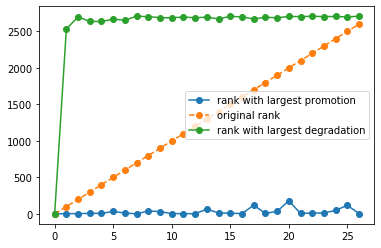

In [10]:
model.eval()
mrr_all = MRR_all(feats, edge_train)
targets, ori_ranks, largest_ranks, smallest_ranks = [], [], [], []
_mrr_all = np.array(mrr_all)[:,0]
ranks = (-_mrr_all).argsort()
for irs in range(len(mrr_all) // 100):
    ir = irs * 100
    print('%d / %d' % (ir, len(mrr_all) // 100))
    t = ranks[ir]
    ori_ranks += [ir]
    targets   += [t]
    '''
    
    calculate promotion and degradation
    
    '''
    
    # given target t
    source_list = train_edge_ori_dict[t]

    mrrs = []

    # remove existing (s, t), i.e. s in source_list
    for s in source_list:
        idx = ((edge_train[:,0] == s) * (edge_train[:,1] == t)).argmax()
        rem_edge_train = torch.cat((edge_train[:idx], edge_train[idx+1:]))
        mrr = MRR(t, feats, rem_edge_train)
        mrrs += [['remove', s, t, mrr]]
    # add edge (s,t), i.e. s not in source_list
#     for s in tqdm(range(feats.shape[0]), desc = 'add'):
    for s in range(feats.shape[0]):
        if s not in source_list:
            rem_edge_train = torch.cat([edge_train, torch.LongTensor([[s, t]]).to(device)])
            mrr = MRR(t, feats, rem_edge_train)
            mrrs += [['add', s, t, mrr]]

    mrrs = np.array(mrrs)
    _mrrs = np.array([i[0] for i in mrrs[:,-1]], dtype=np.float)
#     _sfms = np.array([i[1] for i in mrrs[:,-1]], dtype=np.float)
    
    largest_mrr  = np.max(_mrrs)
    smallest_mrr = np.min(_mrrs)
    
    largest_rank = 0
    smallest_rank = 0
    
    for i in _mrr_all:
        if i > largest_mrr:
            largest_rank += 1
        if i > smallest_mrr:
            smallest_rank += 1
    largest_ranks += [largest_rank]
    smallest_ranks += [smallest_rank]
    print("largest_mrr:",largest_mrr,"inital_mrr",_mrr_all[t],"smallest_mrr",smallest_mrr)
    print("largest_rank:",largest_rank, "ir:",ir, "smallest_rank",smallest_rank)
    
plt.plot(largest_ranks, 'o-', label = 'rank with largest promotion')
plt.plot(ori_ranks, 'o--', label = 'original rank')
plt.plot(smallest_ranks, 'o-', label = 'rank with largest degradation')
plt.legend()
plt.show()